## Interview Challenge 1

### Part 1 ‑ Exploratory data analysis  
<div class="span5 alert alert-info">  The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.
</div>  

In [55]:
# import packages 
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# load login jsons into data frame
filepath = '/Users/brentmarijensen//ultimate_challenge/logins.json'
df = pd.read_json(filepath)

print(type(df))
print(len(df['login_time']))
df_copy = df

<class 'pandas.core.frame.DataFrame'>
93142


In [57]:
print('type', type(df))
print('shape', df.shape)
print('')
print('info',df.info())
print('')
print('columns:',df.columns)
print(df.head())
df.tail()

type <class 'pandas.core.frame.DataFrame'>
shape (93142, 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB
info None

columns: Index(['login_time'], dtype='object')
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


"logins.json" data is a list of datetimes.  No non-null values.  Range from Jan 1 to April 13, 1970, 103 days.  
Histogram below shows no missing days.  The graph shows a weekly pattern.  It appears that Fri and Sat are the busiest days.  Jan 1 1970 was a Thursday.  
Logins steadily increased over the 3.4 months.

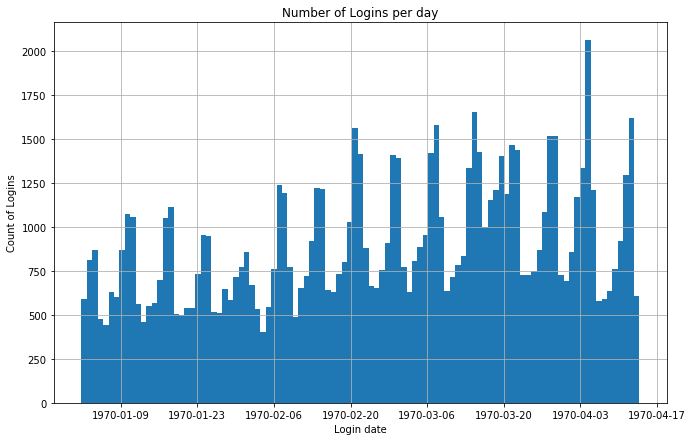

In [58]:
# plot the login data
_= df.login_time.hist(bins=103, figsize=(11,7))
_= plt.title('Number of Logins per day')
_= plt.xlabel('Login date')
_= plt.ylabel('Count of Logins')
plt.show()

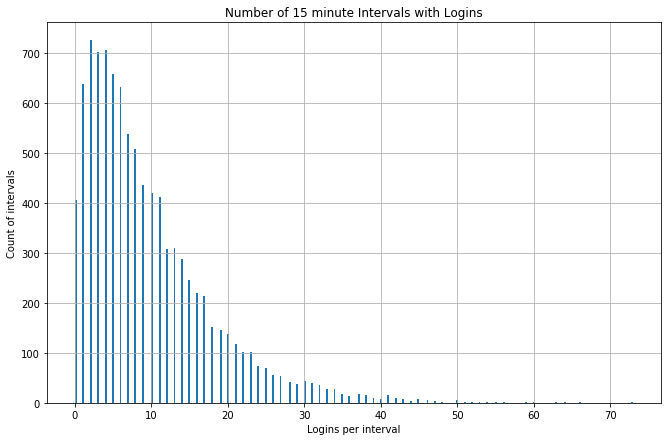

In [59]:
df.set_index(df.login_time, inplace=True)
df.groupby(pd.Grouper(freq = '15Min'))
groups_15m = df.resample('15Min').count()

_= groups_15m.hist(bins=300,figsize=(11,7))
_= plt.title('Number of 15 minute Intervals with Logins')
_= plt.xlabel('Logins per interval')
_= plt.ylabel('Count of intervals')
plt.show()

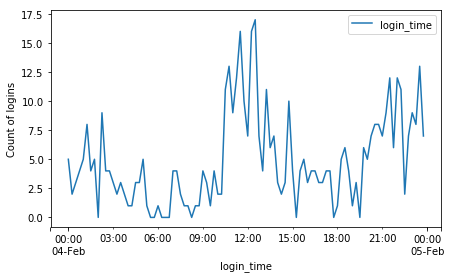

In [61]:
# plot a single day  Feb 4, Wednesday
groups_15m['1970-02-04': '1970-02-04'].plot(figsize=(7,4))
plt.ylabel('Count of logins')
plt.show()

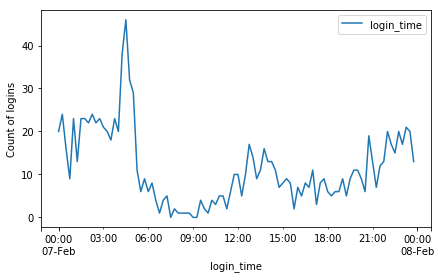

In [62]:
# plot a single day  Feb 7, Saturday
groups_15m['1970-02-07': '1970-02-07'].plot(figsize=(7,4))
plt.ylabel('Count of logins')
plt.show()

On Wed Feb 4, a surge of logins occured from 11am to 3pm, with another surge late at night from 9pm to 2am.  This may reflect lunch time riders or food deliveries, and late night rides home from bars or restaurants.  
On Sat Feb 7, logins were heavy from 12am to 4am, with a large surge at 4am!  (Is last call in Gotham at 4am?)  
Sat logins far outpaced Wed logins.  
Note: this is just a quick sample of two days.  Below is a count of each day of the week, and each hour of the day, cumulative over the 103 day period.

In [63]:
# count number of rides by day of the week and by hour of the day
df['day_of_week'] = (pd.DatetimeIndex(df.index).dayofweek)
print('number of rides by day of the week (Sun-Sat):')
print(df['day_of_week'].value_counts().sort_index())
df['weekend'] = (df.day_of_week // 5 == 1).astype(float)
df["weekday"] = (df.day_of_week < 5).astype(float)
print('weekend total:', df.weekend.sum(), 'per day:', df.weekend.sum()/2)
print('weekday total:', df.weekday.sum(), 'per day:', df.weekday.sum()/5)

print(' ')
df['hour'] = (pd.DatetimeIndex(df.index).hour)
print('number of rides by hour of day:')
print(df.hour.value_counts().sort_index())

number of rides by day of the week (Sun-Sat):
0     8823
1     9268
2    10339
3    11960
4    15208
5    19377
6    18167
Name: day_of_week, dtype: int64
weekend total: 37544.0 per day: 18772.0
weekday total: 55598.0 per day: 11119.6
 
number of rides by hour of day:
0     5993
1     6317
2     5800
3     4831
4     5034
5     2945
6     1138
7      815
8      818
9     1527
10    3064
11    5799
12    4964
13    3611
14    3426
15    3038
16    2832
17    2584
18    2980
19    3235
20    4103
21    5623
22    6607
23    6058
Name: hour, dtype: int64


Text(0.5,1,'Logins by day_of_week')

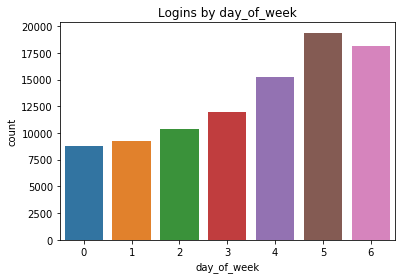

In [66]:
sns.countplot(df.day_of_week)
plt.title('Logins by day_of_week')

Text(0.5,1,'Logins by hour')

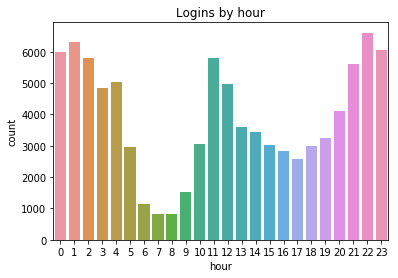

In [65]:
sns.countplot(df.hour)
plt.title('Logins by hour')

### Part 2 ‑ Experiment and metrics design  
<div class="span5 alert alert-info">  The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.  
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
a. how you will implement the experiment  
b. what statistical test(s) you will conduct to verify the significance of the observation  
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  
</div>

1 To answer the question directly, we could count number of drivers who cross the bridge.  Measure logins on the bridge between the cities.  

However, I sense an assumption that more driver mobility might increase availability and thus rider engagement and satisfaction.  It's good to check.  I'd measure engagement and satisfaction.  These metrics should be available by ratings, number of rides, and wait times.   

I'd also measure change in revenue.  If profitability doesn't increase, it may not be worth the cost.

2 I propose an A/B test with random drivers reimbursed for bridge tolls, and others not.  The test should run for several weeks, to factor out day variability and seasonality.  Measure *bridge logins*, to see if they make use of the program, and then measure *user ratings*, *number of rides*, *wait times*, and *revenue*.  Compare the metrics between pilot group to control group, and measure statistical significance with a hypothesis test.  

If the test does not show significant benefit, I recommend to discontinue the test.  
If the test shows a significant change and benefit, then I'd provide a report of all the measurements, and recommend a full rollout.  
A full rollout could be 100% reimbursement to all drivers, or the reimbursement could be used as incentive for drivers who hit minimum numbers of hours or rides.  It could also be used at certain times or days (with the hope that drivers might cross the bridge more often even when not reimbursed.)  

### Part 3 ‑ Predictive modeling
<div class="span5 alert alert-info">  
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.  
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?  
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?  Include any key indicators of model performance.  
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).   
Data description:  
● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYYMMDD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday  
</div>

In [69]:
# import packages 
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

# load login jsons into data frame
# I was unable to open it directly with pd.read_json, got ValueError, so there is bad data
filepath2 = '/Users/brentmarijensen//ultimate_challenge/ultimate_data_challenge.json'
with open(filepath2) as file:
    data = json.load(file)
ultimate = pd.DataFrame(data)

print(type(ultimate))
print(len(ultimate))
ultimate_copy = ultimate

<class 'pandas.core.frame.DataFrame'>
50000


In [70]:
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [71]:
print('type', type(ultimate))
print('shape', ultimate.shape)
print('')
print('info',ultimate.info())
print('')
print('columns:',ultimate.columns)

ultimate.tail()

type <class 'pandas.core.frame.DataFrame'>
shape (50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
info None

columns: Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       't

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


Nulls exist in **avg_rating_by_driver**, **avg_rating_of_driver** and **phone**.  It's possible that no ratings exist for some drivers **by** or **of**.  It's surprising that some records were entered without valid phone type.  In prediction, this might be useful information, and an integer is easier to work with.  Let's fill these NaNs with -1.  For the missing **ratings**, I can't assume a good or bad rating.  I will fill with average rating.  

In [72]:
ultimate.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [73]:
ultimate['phone'] = ultimate['phone'].fillna(-1)

In [74]:
ultimate.phone.value_counts()

iPhone     34582
Android    15022
-1           396
Name: phone, dtype: int64

In [75]:
print('total ratings by driver:',ultimate['avg_rating_by_driver'].value_counts().sum())
ultimate['avg_rating_by_driver'].value_counts()

total ratings by driver: 49799


5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

In [76]:
ultimate['avg_rating_by_driver'].fillna(ultimate['avg_rating_by_driver'].mean(), inplace=True)
ultimate['avg_rating_of_driver'].fillna(ultimate['avg_rating_of_driver'].mean(), inplace=True)

In [77]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


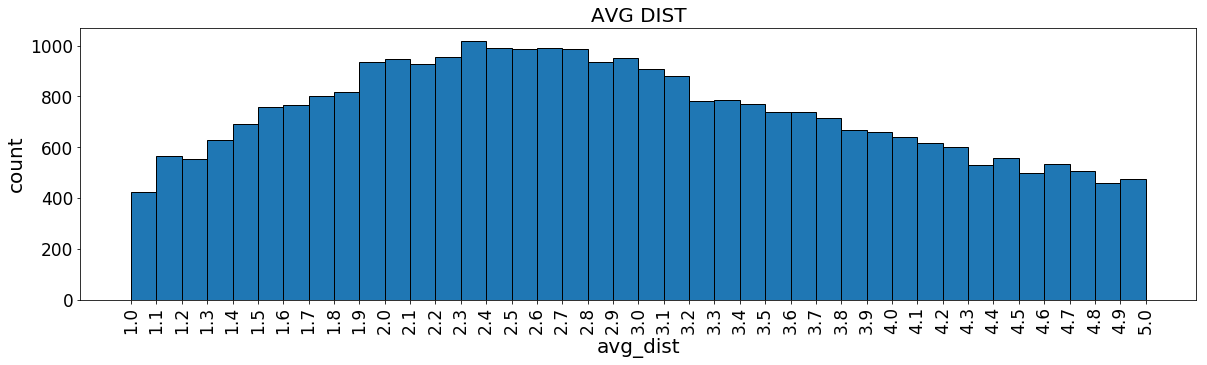

mean average: 5.7968
median average: 3.8800
max average: 160.96
min average: 0.0


In [78]:
# average distribution.  
import matplotlib.pyplot as plt
import seaborn as sns

bins= np.arange(1,5.1,0.1)   # bins from 1 to 5, increments of 0.1
_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['avg_dist'], bins=bins, edgecolor="k") #
_= plt.xticks(bins, rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('AVG DIST', size=20)
_= plt.xlabel('avg_dist', size=20)
_= plt.ylabel('count', size=20)
plt.show()

print('mean average: {:.4f}'.format(ultimate['avg_dist'].mean()))
print('median average: {:.4f}'.format(ultimate['avg_dist'].median()))
print('max average:', ultimate['avg_dist'].max())
print('min average:', ultimate['avg_dist'].min())

In [79]:
# a few  mean aveerages are very large!  Let's examine: 
# breweries = df.brewery.value_counts()
ultimate.sort_values(by='avg_dist', ascending=False).head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
20701,160.96,4.778158,4.601559,1.0,Astapor,2014-06-26,Android,2014-01-25,0.0,0,False,100.0
534,129.89,5.000000,4.601559,1.0,King's Landing,2014-03-09,-1,2014-01-04,0.0,0,False,0.0
1302,79.69,5.000000,5.000000,1.0,Winterfell,2014-01-30,iPhone,2014-01-30,0.0,1,False,100.0
22290,79.34,5.000000,5.000000,1.0,Astapor,2014-06-26,iPhone,2014-01-12,0.0,0,True,100.0
47595,77.13,5.000000,5.000000,1.0,King's Landing,2014-06-09,iPhone,2014-01-25,0.0,0,True,0.0
36625,73.88,3.000000,5.000000,1.0,Astapor,2014-01-22,iPhone,2014-01-19,0.0,2,False,100.0
22096,72.20,5.000000,4.601559,1.0,Astapor,2014-05-01,iPhone,2014-01-17,0.0,0,True,100.0
1493,72.08,5.000000,5.000000,1.0,Astapor,2014-01-27,iPhone,2014-01-26,0.0,1,False,100.0
19197,71.38,5.000000,4.700000,1.0,Astapor,2014-05-14,iPhone,2014-01-17,0.0,2,True,100.0
42835,70.48,5.000000,5.000000,1.0,Winterfell,2014-06-28,Android,2014-01-10,0.0,0,False,100.0


In [80]:
values = ultimate.avg_dist.value_counts().reset_index()
print(values)

      index  avg_dist
0      0.00       150
1      2.30       116
2      2.29       116
3      2.70       114
4      2.36       114
5      2.73       114
6      2.65       113
7      2.50       113
8      2.83       110
9      2.54       110
10     2.40       110
11     2.15       109
12     2.05       109
13     2.42       109
14     2.32       108
15     2.62       108
16     2.47       107
17     2.01       107
18     2.89       107
19     2.74       107
20     3.05       106
21     2.60       106
22     2.06       106
23     3.00       106
24     2.59       106
25     2.77       105
26     2.22       104
27     2.92       104
28     2.38       103
29     2.46       103
...     ...       ...
2878  24.05         1
2879  30.27         1
2880  33.55         1
2881  25.81         1
2882  31.22         1
2883  23.55         1
2884  36.63         1
2885  45.56         1
2886  21.75         1
2887  31.78         1
2888  30.22         1
2889  20.20         1
2890  33.77         1
2891  29.3

I'm unsure what to make of these high ratings.  It's possible they are not in error.  I'll leave them as they are.

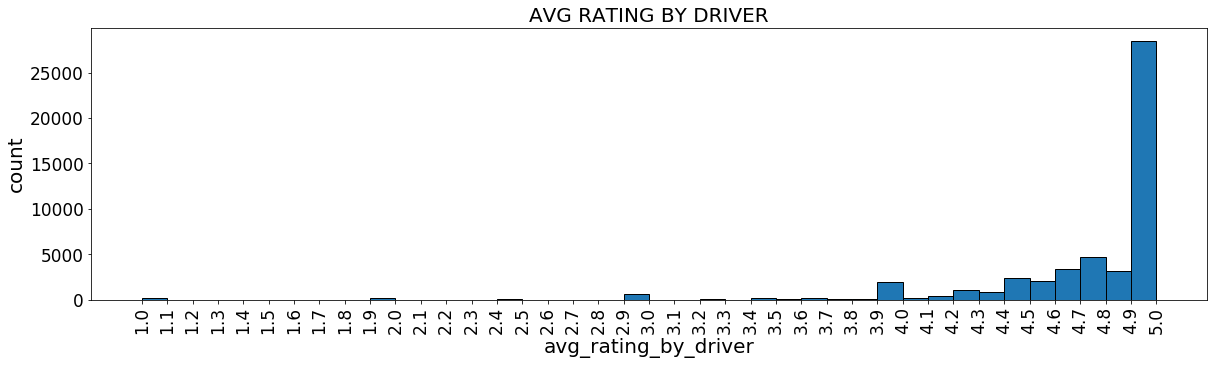

mean average rating: 4.7782
max average rating: 5.0
min average rating: 1.0


In [81]:
# average rating by driver.  
import matplotlib.pyplot as plt

bins= np.arange(1,5.1,0.1)   # bins from 1 to 5, increments of 0.1
_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['avg_rating_by_driver'], bins=bins, edgecolor="k") #
_= plt.xticks(bins, rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('AVG RATING BY DRIVER', size=20)
_= plt.xlabel('avg_rating_by_driver', size=20)
_= plt.ylabel('count', size=20)
plt.show()

print('mean average rating: {:.4f}'.format(ultimate['avg_rating_by_driver'].mean()))
print('max average rating:', ultimate['avg_rating_by_driver'].max())
print('min average rating:', ultimate['avg_rating_by_driver'].min())

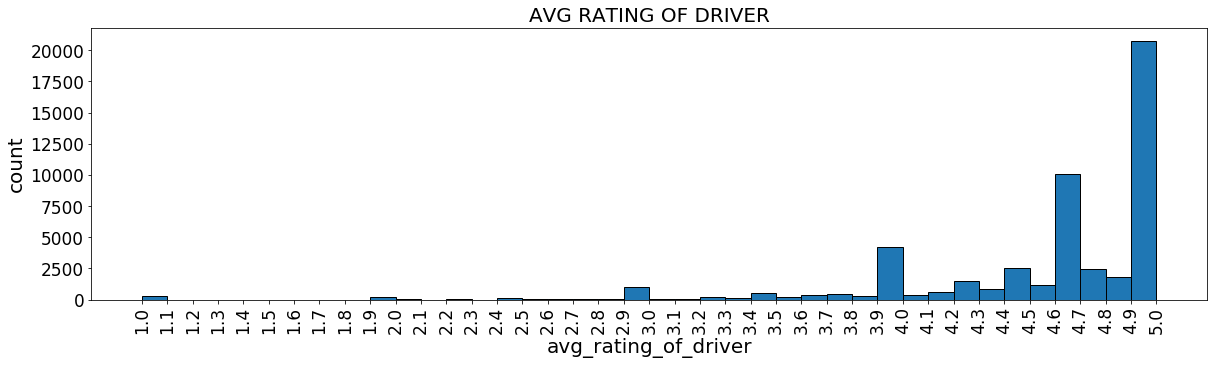

mean average rating: 4.6016
max average rating: 5.0
min average rating: 1.0


In [82]:
# average rating of driver.  
import matplotlib.pyplot as plt

bins= np.arange(1,5.1,0.1)   # bins from 1 to 5, increments of 0.1
_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['avg_rating_of_driver'], bins=bins, edgecolor="k") #
_= plt.xticks(bins, rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('AVG RATING OF DRIVER', size=20)
_= plt.xlabel('avg_rating_of_driver', size=20)
_= plt.ylabel('count', size=20)
plt.show()

print('mean average rating: {:.4f}'.format(ultimate['avg_rating_of_driver'].mean()))
print('max average rating:', ultimate['avg_rating_of_driver'].max())
print('min average rating:', ultimate['avg_rating_of_driver'].min())

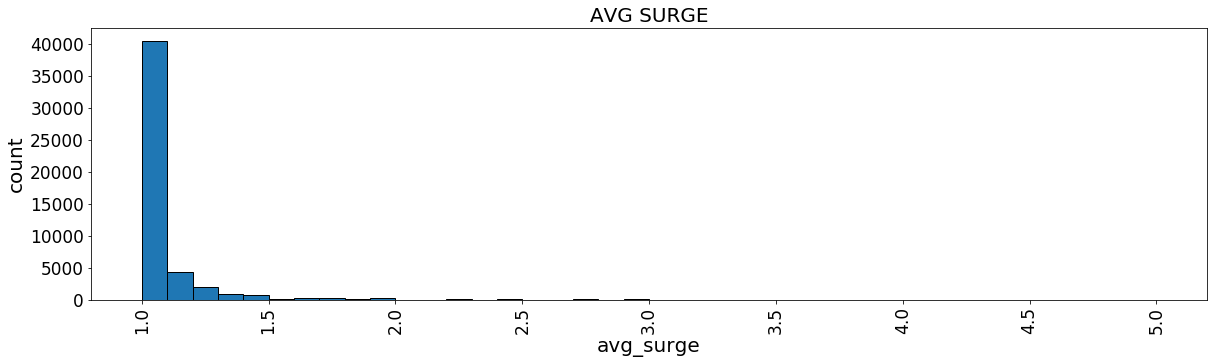

mean average surge: 1.0748
max average surge: 8.0
min average surge: 1.0


In [83]:
# average avg_surge.  
import matplotlib.pyplot as plt

_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['avg_surge'], bins=bins, edgecolor="k") #
_= plt.xticks(rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('AVG SURGE', size=20)
_= plt.xlabel('avg_surge', size=20)
_= plt.ylabel('count', size=20)
plt.show()

print('mean average surge: {:.4f}'.format(ultimate['avg_surge'].mean()))
print('max average surge:', ultimate['avg_surge'].max())
print('min average surge:', ultimate['avg_surge'].min())

In [84]:
print(ultimate.city.value_counts())

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


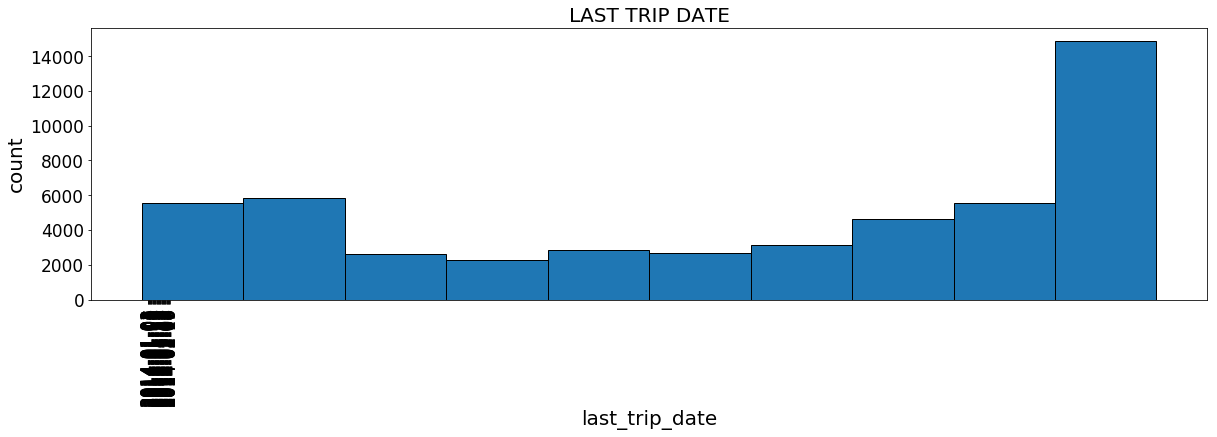

mean average rating: 4.6016
max average rating: 5.0
min average rating: 1.0


In [87]:
# average last_trip_date.  
import matplotlib.pyplot as plt

_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['last_trip_date'], edgecolor="k") #
_= plt.xticks(bins, rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('LAST TRIP DATE', size=20)
_= plt.xlabel('last_trip_date', size=20)
_= plt.ylabel('count', size=20)
plt.show()

print('mean average rating: {:.4f}'.format(ultimate['avg_rating_of_driver'].mean()))
print('max average rating:', ultimate['avg_rating_of_driver'].max())
print('min average rating:', ultimate['avg_rating_of_driver'].min())

In [91]:
# RETAINED: use as the target
# use function to sift through the datetime data quickly# use fun 
ultimate['retained'] = ultimate['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

# Getting the specific retention numbers, 0 not retained, 1 retained# Getting 
retained = ultimate['retained'].value_counts()
retained_percent = retained[1]/len(df)
print(retained, '\n', '\n','Retention Rate:', retained_percent)

TypeError: Cannot compare type 'Timestamp' with type 'str'

In [ ]:

active_ind = (pd.to_datetime(pred_data["last_trip_date"]) < pd.to_datetime(max(pred_data["last_trip_date"])) - pd.Timedelta("30 days")) + 0
active_ind.value_counts()

In [ ]:
# average avg_surge.  
import matplotlib.pyplot as plt

_= plt.figure(figsize=(20,5))
_= plt.hist(ultimate['avg_surge'], bins=bins, edgecolor="k") #
_= plt.xticks(rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('AVG SURGE', size=20)
_= plt.xlabel('avg_surge', size=20)
_= plt.ylabel('count', size=20)

plt.show()

In [ ]:
#from stack overflow:
agg_10m = df.groupby(pd.Grouper(freq='10Min')).aggregate(numpy.sum)

---

You can use DataFrame.resample:

df2 = df.resample(rule='15Min', on='datetime').mean()
Then you filter out the times you don't want using boolean indexing. It's better to work with a DateTimeIndex:

df2 = df2.set_index('datetime', drop=False)
df2.between_time('9:00','16:30')

---

df.index = pd.DatetimeIndex(df[1])
df.loc[df[2]=='reward', 'rwg'] = range(1, sum(df[2]=='reward')+1 )
dfrwg = df.groupby('rwg').sum()
dfrs = df.resample('3min', how=sum)
print(dfrwg)

---

df.index = pd.to_datetime(df.data, format='%d/%b/%Y:%H:%M:%S')
df.groupby(pd.TimeGrouper('5Min')).apply(lambda x: x.groupby(['id', 'subdomain']).first())
df1.resample("5Min").sum()

---

df.groupby(pd.TimeGrouper(freq='60Min', base=30, label='right')).first()
# same thing using resample - df.resample('60Min', base=30, label='right').first()